# Imports

In [108]:
### General ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
from sklearn.preprocessing import StandardScaler

### Maps ###
import folium
from geopy import distance

### Principal Component Analysis ###
import json
import gzip
from sklearn.decomposition import PCA
from scipy import cluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import chi2_contingency, pearsonr
from itertools import combinations
import sys
sys.path.append("lib")
from sklearn import decomposition
from sklearn.manifold import TSNE
from ggplot import *
from sklearn.decomposition import TruncatedSVD

# Create the feature matrix

The aim of the feature matrix is to use the message_id as the unique key of the table. This means that we have to build several one-hot encoders in order not to loose information. 

For example, if we have 10 base stations that got the message, we need to gather the information of those 10 lines in just 1.

Actually, we need one-hot encoders for :
- the RSSI of each antenna that received the message
- the nseq of each antenna that received the message
- the longitude of each antenna that received the message
- the latitude of each antenna that received the message

We merge the train and test samples, as the number of base stations is not the same in both cases, so we need to have the same number of columns generated by the one hot encoder. We will split them again later on.

In [109]:
df_mess_train = pd.read_csv('datas/df_mess_train_2.csv')
pos_train = pd.read_csv('datas/pos_train_list.csv')

In [110]:
df_mess_test = pd.read_csv('datas/df_mess_test_2.csv')

In [111]:
df_mess_train.shape

(39250, 9)

In [112]:
df_mess_test.shape

(29286, 9)

We create a dataset that contains both the train sample and the exact location. This will be our reference train set.

In [113]:
df = pd.concat([df_mess_train, df_mess_test], axis=0).reset_index()

In [114]:
df = df.drop(['Unnamed: 0', 'index'], axis=1)

In [115]:
df.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [116]:
df.shape

(68536, 8)

## Estimate RSSI of unobserved base stations

As discussed in the exploration notebook, we have an issue with base stations that have not received a given message. To increase the robustness of our estimates, we will compute the RSSI of the base stations that did not receive the message using a KNN classifier using only the latitude and longitude of the base stations that did actually receive the message.

In [117]:
message = df['messid'].unique().tolist()

In [118]:
base_stations = df[['bsid', 'did', 'bs_lat', 'bs_lng']]
base_stations = base_stations.drop_duplicates()

In [119]:
pd.get_dummies(base_stations).shape

(6785, 4)

In [120]:
base_stations = base_stations.reset_index().drop(['index'], axis = 1)

In [121]:
stations = base_stations[['bsid','bs_lat', 'bs_lng']].drop_duplicates().reset_index().drop(['index'], axis=1)
list_stations = stations['bsid']

## Prepare several One-Hot-Encoders

In [122]:
one_hot = pd.get_dummies(df['bsid'])

In [123]:
#We give new names to the columns to avoid duplicates
one_hot_nseq = pd.get_dummies(df['nseq'])

one_hot_empty = one_hot.rename(columns={x:'isbs' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})

one_hot_rssi = one_hot.rename(columns={x:'rssi' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})
one_hot_distance_power = one_hot.rename(columns={x:'distpwr' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})

one_hot_lat = one_hot.rename(columns={x:'lati' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})
one_hot_lng = one_hot.rename(columns={x:'lngi' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})

one_hot_distance_station = one_hot.rename(columns={x:'distbs' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})

one_hot_time = one_hot.rename(columns={x:'time' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})


Another varible of interest is the number of base stations that received the message. As we will later on group values by message_id, we can set this new column to 1 everywhere, and the group by with a sum will give us the number of distinct base stations that received the message.

In [124]:
df['NBAntennes'] = 1

In [125]:
# Join the encoded df
df = df.join(one_hot_rssi)

In [126]:
#Check the result df
df.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,NBAntennes,rssi1,...,rssi250,rssi251,rssi252,rssi253,rssi254,rssi255,rssi256,rssi257,rssi258,rssi259
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,1,0,...,0,0,0,0,0,0,0,0,0,0
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,1,0,...,0,0,0,0,0,0,0,0,0,0
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,1,0,...,0,0,0,0,0,0,0,0,0,0
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,1,0,...,0,0,0,0,0,0,0,0,0,0
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,1,0,...,0,0,0,0,0,0,0,0,0,0


It is quite useless to store juste 0's and 1's. Instead, we will multiply the encoder on each line by the RSSI. This way, the final table will have for each base station the RSSI store on a single line. 

In [127]:
df.iloc[:,9:] = df.iloc[:,9:].multiply(df["rssi"], axis="index")

## Computing distances

### Distance between base station and message using RSSI

According to the paper "Exploiting machine learning strategies and RSSI for localization in wireless sensor networks: A survey" written in 2017 by Hanen Ahmadi and Ridha Bouallegue, the following relationship holds.

<img src='images/theory.png'>

In [128]:
power_up_dbm = max(df['rssi']) # Pour distance de 1km, correspond au max RSSI par approximation
lambda_onde = (2.8 * 10 ** 8)/ (868 * 10 ** 6) # onde sigfox => 868MHz
kc = 20 * np.log((4 * np.pi)/ lambda_onde)
etha = 4 #Urbain moyen

In [129]:
df['distance_to_station'] = 10**((power_up_dbm + kc - df['rssi']) / ( 10 * etha))

In [130]:
df.shape

(68536, 269)

Once again, this information should be stored in a one-hot encoder to have it on a single line when we apply the "group by".

In [131]:
df = df.join(one_hot_distance_power)

In [132]:
df.iloc[:,269:] = df.iloc[:,269:].multiply(df["distance_to_station"], axis="index")

In [133]:
df.shape

(68536, 528)

### Distance between the base station and the barycenter

Another importante distance measure is the geodesic distance, which is the minimal distance between two points on a sphere. This will be useful to measure the distance between base stations and a median barycenter point. This will allow us to identify outlying points too.

In [134]:
lat_dis = np.mean(df['bs_lat'])
lng_dis = np.mean(df['bs_lng'])
print(lat_dis, lng_dis)

41.36226017381674 -102.71741548489203


In [135]:
map = folium.Map(location=[lat_dis, lng_dis], zoom_start=9.5, )
folium.CircleMarker(location = [lat_dis, lng_dis], radius=10,
                    ).add_to(map)
map.save('maps/map-center.html')

In [136]:
%%HTML
<iframe width=100% height=550 src="maps/map-center.html"></iframe>

After the initial outlier correction, the base stations are located here :

In [138]:
map = folium.Map(location=[39.73, -104.958490], zoom_start=5)
for eq in df.iterrows() :
    folium.CircleMarker(location = [eq[1]['bs_lat'], eq[1]['bs_lng']], radius=1,color='blue').add_to(map)
map.save('maps/map_bs.html')

In [139]:
%%HTML
<iframe width=100% height=550 src="maps/map_bs.html"></iframe>

In [140]:
df['distance_to_center'] = np.arccos( np.sin(np.radians(df['bs_lat'])) * np.sin(np.radians(lat_dis)) + np.cos(np.radians(df['bs_lat'])) * np.cos(np.radians(lat_dis)) * np.cos( np.radians(lng_dis - df['bs_lng'])))
df = df.join(one_hot_distance_station)
df.iloc[:,529:] = df.iloc[:,529:].multiply(df["distance_to_center"], axis="index")

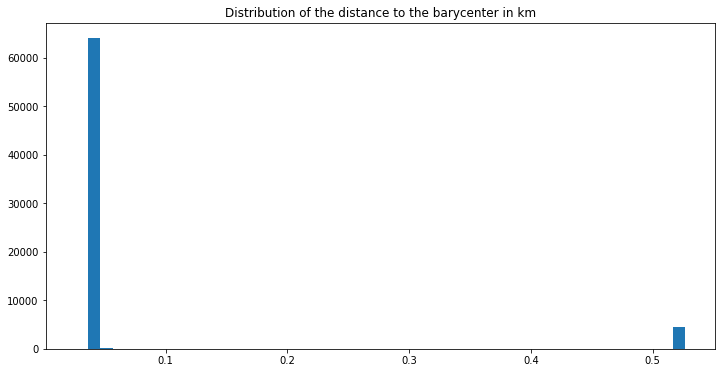

In [141]:
plt.figure(figsize=(12,6))
plt.title('Distribution of the distance to the barycenter in km')
plt.hist(df['distance_to_center'], bins=50)
plt.show()

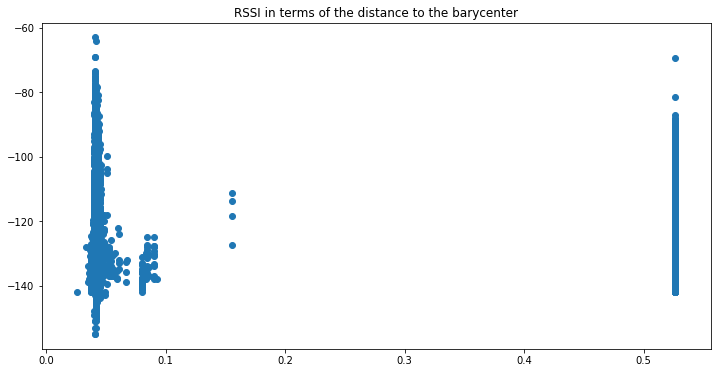

In [142]:
plt.figure(figsize=(12,6))
plt.title('RSSI in terms of the distance to the barycenter')
plt.scatter(df['distance_to_center'], df['rssi'])
plt.show()

We observe that the RSSI tends to decrease with the distance to the barycenter of the base stations.

## The nseq

First, there are some columns that are now encoded in the one hot encoder that are not needed anymore.

In [143]:
df = df.drop('rssi',axis = 1)
df = df.drop('distance_to_station',axis = 1)
df = df.drop('bsid',axis = 1)
df = df.drop('distance_to_center', axis=1)

Regarding the nseq, to the extend of our understanding : 
Everytime the Sigfox module send a message, it increments this nseq by a given value. This allows us to check if we are not loosing messages from a backend for example. 

We can encode it too, but not on the base station, but on the values that the 'nseq' takes.

In [144]:
df = df.join(one_hot_nseq)

In [145]:
df = df.drop('nseq',axis = 1)

What does our data set look like now ?

In [146]:
df.shape

(68536, 788)

We have a pretty consequent number of columns now, but we still need to add the latitude and the longitude of every base station in order not to loose this information when grouping.

In [147]:
df_nseq = df_mess_train[['nseq', 'bs_lat', 'bs_lng']].join(pos_train[['lat', 'lng']])

def compute_geodist(df):
    coords_1 = (df['lat'], df['lng'])
    coords_2 = (df['bs_lat'], df['bs_lng'])
    dist = distance.distance(coords_1, coords_2)
    return round(float(str(dist).split(" ")[0]), 1)

df_nseq['geodist'] = df_nseq.apply(compute_geodist, axis=1)
df_nseq.head()

,nseq,bs_lat,bs_lng,lat,lng,geodist
0,0.5,39.617794,-104.954917,39.606690,-104.958490,1.3
1,2.0,39.677251,-104.952721,39.606690,-104.958490,7.8
2,1.0,39.612745,-105.008827,39.637741,-104.958554,5.1
3,2.0,39.797969,-105.073460,39.730417,-104.968940,11.7
4,1.0,39.723151,-104.956216,39.730417,-104.968940,1.4


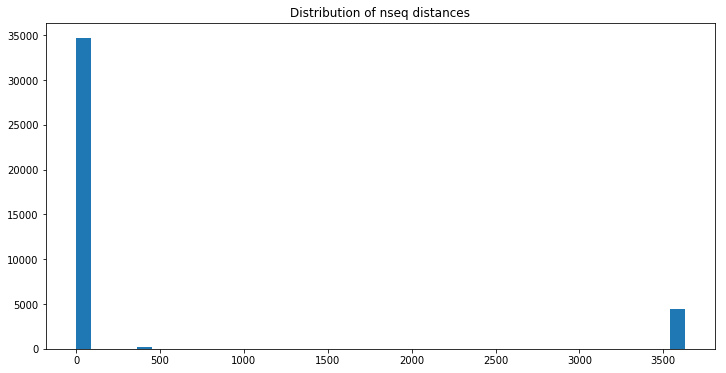

In [148]:
plt.figure(figsize=(12,6))
plt.hist(df_nseq['geodist'], bins = 40)
plt.title('Distribution of nseq distances')
plt.show()

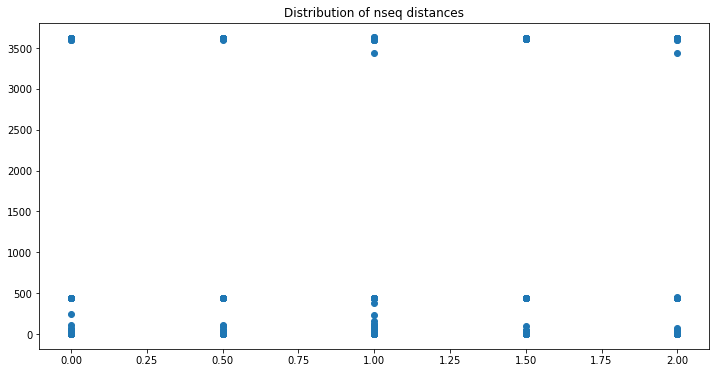

In [149]:
plt.figure(figsize=(12,6))
plt.scatter(df_nseq['nseq'], df_nseq['geodist'])
plt.title('Distribution of nseq distances')
plt.show()

## The time_ux

In [150]:
df = df.join(one_hot_time)
df.shape

(68536, 1047)

In [151]:
df.iloc[:,788:] = df.iloc[:,788:].multiply(df["time_ux"], axis="index")

## Encoding the latitude and longitude

We have already preparerd those encoders at the first step, we just need to apply the Join.

In [152]:
df = df.join(one_hot_lat)
df.iloc[:,1047:] = df.iloc[:,1047:].multiply(df["bs_lat"], axis="index")

In [153]:
df = df.join(one_hot_lng)
df.iloc[:,1306:] = df.iloc[:,1306:].multiply(df["bs_lng"], axis="index")

In [154]:
df.shape

(68536, 1565)

In [155]:
df = df.drop(['bs_lat', 'bs_lng', 'time_ux'], axis=1)

## Add some more features and scale 

Some columns might only contain 0's. For this reason, they should be dropped.

In [156]:
df = df.loc[:, (df != 0).any(axis=0)]

In [157]:
df.shape

(68536, 1562)

Additional features that are interesting to add include :
- overall distance : a sum of the distances to all base stations. We will also consider average, and log.
- overall RSSI : a sum of all RSSI's that near by base stations received for a given message. We will also consider the log of the sum.
- average latitude of base stations, as well as sum
- average longitude of base stations, as well as sum

In [158]:
def feature_eng(df) :
    df['sum_dist'] = np.sum(df.filter(like='dist'), axis=1)
    df['avg_dist'] = np.mean(df.filter(like='dist'), axis=1)
    
    df['sum_rssi'] = np.sum(df.filter(like='rssi'), axis=1)
    df['avg_rssi'] = np.mean(df.filter(like='rssi'), axis=1)
    
    df['avg_lat'] = np.mean(df.filter(like='lati'), axis=1)
    df['avg_lng'] = np.mean(df.filter(like='lngi'), axis=1)
    
    df['sum_lat'] = np.sum(df.filter(like='lati'), axis=1)
    df['sum_lng'] = np.sum(df.filter(like='lngi'), axis=1)
    return df

In [159]:
df = feature_eng(df)

## Scale the data set

We should scale the datas to avoid setting to much importance on large variance columns.

In [160]:
df = pd.concat([df[['messid', 'NBAntennes', 'did']], (df.drop(['messid', 'NBAntennes', 'did'], axis=1)-df.drop(['messid', 'NBAntennes', 'did'], axis=1).mean())/df.drop(['messid', 'NBAntennes', 'did'], axis=1).std()], axis=1)
                          

In [161]:
df.head()

,messid,NBAntennes,did,rssi1,rssi2,rssi3,rssi4,rssi5,rssi6,rssi7,...,lngi258,lngi259,sum_dist,avg_dist,sum_rssi,avg_rssi,avg_lat,avg_lng,sum_lat,sum_lng
0,573bf1d9864fce1a9af8c5c9,1,473335.0,0.00382,0.00382,0.00382,0.006608,0.010796,0.048968,0.039159,...,0.077854,0.00382,-0.696423,-0.696423,0.475266,0.475266,-0.290454,-0.249946,-0.290454,-0.249946
1,573bf1d9864fce1a9af8c5c9,1,473335.0,0.00382,0.00382,0.00382,0.006608,0.010796,0.048968,0.039159,...,0.077854,0.00382,-0.342191,-0.342191,0.089482,0.089482,-0.280555,-0.249701,-0.280555,-0.249701
2,573bf3533e952e19126b256a,1,473335.0,0.00382,0.00382,0.00382,0.006608,0.010796,0.048968,0.039159,...,0.077854,0.00382,0.975539,0.975539,-0.902533,-0.902533,-0.291295,-0.255968,-0.291295,-0.255968
3,573c0cd0f0fe6e735a699b93,1,473953.0,0.00382,0.00382,0.00382,0.006608,0.010796,0.048968,0.039159,...,0.077854,0.00382,0.621127,0.621127,-0.682085,-0.682085,-0.260455,-0.263188,-0.260455,-0.263188
4,573c0cd0f0fe6e735a699b93,1,473953.0,0.00382,0.00382,0.00382,0.006608,0.010796,0.048968,0.039159,...,0.077854,0.00382,-0.827709,-0.827709,0.640602,0.640602,-0.272912,-0.250091,-0.272912,-0.250091


## Split and build the training set

It is now time to concatenate the dataframe we have worked on with the exact GPS location of pos_train data set. We need to split the data sets again now.

In [162]:
df.shape

(68536, 1570)

In [163]:
df_train = df.iloc[:39250]

In [164]:
df_train.shape

(39250, 1570)

In [165]:
df_test = df.iloc[39250:]

In [166]:
df_test.shape

(29286, 1570)

In [167]:
df_train = pd.concat([df_train, pos_train], axis=1)

In [168]:
df_train.describe()

,NBAntennes,did,rssi1,rssi2,rssi3,rssi4,rssi5,rssi6,rssi7,rssi8,...,sum_dist,avg_dist,sum_rssi,avg_rssi,avg_lat,avg_lng,sum_lat,sum_lng,lat,lng
count,39250.0,3.925000e+04,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,...,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000,39250.000000
mean,1.0,4.835932e+05,-0.002850,-0.002850,-0.002850,-0.004931,-0.008055,0.005749,-0.004348,-0.014362,...,0.014597,0.014597,-0.005705,-0.005705,0.198591,0.195235,0.198591,0.195235,39.783333,-105.056343
std,0.0,9.893140e+04,1.321416,1.321416,1.321416,1.321402,1.321366,0.931029,1.052530,1.282735,...,1.017247,1.017247,1.016981,1.016981,1.285847,1.287178,1.285847,1.287178,0.206262,0.162954
min,1.0,4.732880e+05,-261.789992,-261.789992,-261.789992,-158.282075,-99.792022,-22.562400,-26.429609,-45.401266,...,-2.225487,-2.225487,-3.217235,-3.217235,-0.883929,-0.530135,-0.883929,-0.530135,35.770683,-107.630679
25%,1.0,4.761230e+05,0.003820,0.003820,0.003820,0.006608,0.010796,0.048968,0.039159,0.022277,...,-0.741451,-0.741451,-0.737197,-0.737197,-0.268867,-0.263281,-0.268867,-0.263281,39.708599,-105.060463
50%,1.0,4.763150e+05,0.003820,0.003820,0.003820,0.006608,0.010796,0.048968,0.039159,0.022277,...,-0.062733,-0.062733,-0.167707,-0.167707,-0.261185,-0.259862,-0.261185,-0.259862,39.776882,-105.039440
75%,1.0,4.766090e+05,0.003820,0.003820,0.003820,0.006608,0.010796,0.048968,0.039159,0.022277,...,0.705941,0.705941,0.530378,0.530378,-0.253667,-0.254807,-0.253667,-0.254807,39.805279,-105.018730
max,1.0,1.747448e+06,0.003820,0.003820,0.003820,0.006608,0.010796,0.048968,0.039159,0.022277,...,8.633011,8.633011,6.813140,6.813140,3.819144,3.822350,3.819144,3.822350,43.140387,-102.094289


We can plot the distribution of the *scaled* distance between the message geolocation and the barycenter.

In [169]:
mess = np.arccos( np.sin(np.radians(df_train['lat'])) * np.sin(np.radians(lat_dis)) + np.cos(np.radians(df_train['lat'])) * np.cos(np.radians(lat_dis)) * np.cos( np.radians(lng_dis - df_train['lng'])))*6378137/1000    


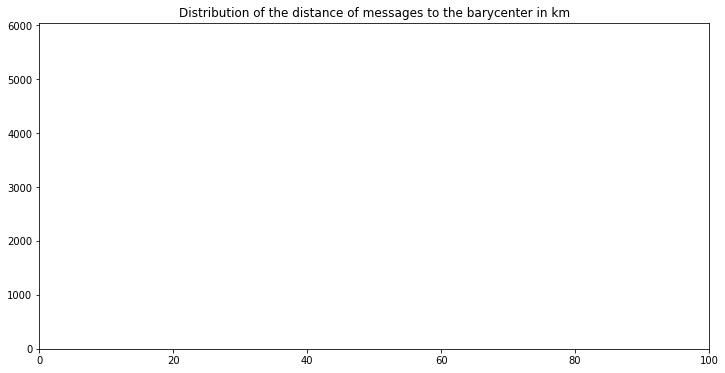

In [170]:
plt.figure(figsize=(12,6))
plt.title('Distribution of the distance of messages to the barycenter in km')
plt.hist(mess, bins=500)
plt.xlim(0,100)
plt.show()

## Group by message_id

Alright, the datas are now ready to be grouped by message_id.

In [171]:
df_train = df_train.groupby(['messid', 'did', 'lat', 'lng']).sum().reset_index()
df_train.head()

,messid,did,lat,lng,NBAntennes,rssi1,rssi2,rssi3,rssi4,rssi5,...,lngi258,lngi259,sum_dist,avg_dist,sum_rssi,avg_rssi,avg_lat,avg_lng,sum_lat,sum_lng
0,573bf1d9864fce1a9af8c5c9,473335.0,39.606690,-104.958490,2,0.007640,0.007640,0.007640,0.013217,0.021591,...,0.155708,0.007640,-1.038614,-1.038614,0.564748,0.564748,-0.571009,-0.499647,-0.571009,-0.499647
1,573bf3533e952e19126b256a,473335.0,39.637741,-104.958554,1,0.003820,0.003820,0.003820,0.006608,0.010796,...,0.077854,0.003820,0.975539,0.975539,-0.902533,-0.902533,-0.291295,-0.255968,-0.291295,-0.255968
2,573c0cd0f0fe6e735a699b93,473953.0,39.730417,-104.968940,3,0.011459,0.011459,0.011459,0.019825,0.032387,...,0.233561,0.011459,-2.029680,-2.029680,2.803596,2.803596,-0.804799,-0.765319,-0.804799,-0.765319
3,573c1272f0fe6e735a6cb8bd,476512.0,39.693102,-105.006995,4,0.015279,0.015279,0.015279,0.026434,0.043183,...,0.311415,0.015279,0.043904,0.043904,-0.707569,-0.707569,-1.162423,-1.033559,-1.162423,-1.033559
4,573c8ea8864fce1a9a5fbf7a,476286.0,39.758167,-105.051016,42,0.160432,0.160432,0.160432,0.277553,0.453421,...,3.269860,0.160432,4.347085,4.347085,-0.852783,-0.852783,-11.072712,-10.864657,-11.072712,-10.864657


In [172]:
df_test = df_test.groupby(['messid', 'did']).sum().reset_index()

In [173]:
df_train.shape

(6068, 1572)

In [174]:
df_test.shape

(5294, 1570)

## Wrapping it up in a function

In [175]:
# Feature Matrix construction 
def feat_mat_const(df_mess_train, df_mess_test):
    
    df = pd.concat([df_mess_train, df_mess_test], axis=0).reset_index()
    df = df.drop(['Unnamed: 0', 'index'], axis=1)
    ### One-Hot Encoders ###
    one_hot = pd.get_dummies(df['bsid'])
    one_hot_nseq = pd.get_dummies(df['nseq'])
    one_hot_empty = one_hot.rename(columns={x:'isbs' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})
    one_hot_rssi = one_hot.rename(columns={x:'rssi' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})
    one_hot_distance_power = one_hot.rename(columns={x:'distpwr' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})
    one_hot_lat = one_hot.rename(columns={x:'lati' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})
    one_hot_lng = one_hot.rename(columns={x:'lngi' + str(y) for x,y in zip(one_hot.columns, range(1, len(one_hot.columns)+1))})
    one_hot_distance_station = one_hot.rename(columns={x:'distbs' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})
    one_hot_time = one_hot.rename(columns={x:'time' + str(y) for x,y in zip(one_hot.columns,range(1, len(one_hot.columns)+1))})

    ### Number of base stations ###
    df['NBAntennes'] = 1

    ### One Hot RSSI ###
    df = df.join(one_hot_rssi)
    df.iloc[:,9:] = df.iloc[:,9:].multiply(df["rssi"], axis="index")
    
    ### Distance estimated by RSSI ###
    power_up_dbm = -51.70 
    lambda_onde = (2.8 * 10 ** 8)/ (868 * 10 ** 6)
    kc = 20 * np.log((4 * np.pi)/ lambda_onde)
    etha = 4
    df['distpwr'] = 10**((power_up_dbm + kc - df['rssi']) / ( 10 * etha))
    df = df.join(one_hot_distance_power)
    df.iloc[:,261:] = df.iloc[:,261:].multiply(df["distpwr"], axis="index")
    
    ### Distance of base station to barycenter ###
    lat_dis = np.mean(df['bs_lat'])
    lng_dis = np.mean(df['bs_lng'])
    df['distbs'] = np.arccos( np.sin(np.radians(df['bs_lat'])) * np.sin(np.radians(lat_dis)) + np.cos(np.radians(df['bs_lat'])) * np.cos(np.radians(lat_dis)) * np.cos( np.radians(lng_dis - df['bs_lng'])))*6378137/1000    
    df = df.join(one_hot_distance_station)
    df.iloc[:,529:] = df.iloc[:,529:].multiply(df["distbs"], axis="index")
    
    ### Drop useless columns ###
    df = df.drop('rssi',axis = 1)
    df = df.drop('distpwr',axis = 1)
    df = df.drop('bsid',axis = 1)
    df = df.drop('distbs', axis=1)
    
    ### One Hot Nseq ###
    df = df.join(one_hot_nseq)
    df = df.drop('nseq',axis = 1)
    
    ### One Hot time_ux ###
    df = df.join(one_hot_time)
    df.iloc[:,788:] = df.iloc[:,788:].multiply(df["time_ux"], axis="index")

    ### One Hot latitude ###
    df = df.join(one_hot_lat)
    df.iloc[:,1047:] = df.iloc[:,1047:].multiply(df["bs_lat"], axis="index")
    
    ### One Hot longitude ###
    df = df.join(one_hot_lng)
    df.iloc[:,1306:] = df.iloc[:,1306:].multiply(df["bs_lng"], axis="index")
    
    ### Drop useless columns ###
    df = df.drop(['bs_lat', 'bs_lng', 'time_ux'], axis=1)
    
    ### Additional feature engineering ### 
    df = df.loc[:, (df != 0).any(axis=0)]
    df['sum_dist'] = np.sum(df.filter(like='dist'), axis=1)
    df['avg_dist'] = np.mean(df.filter(like='dist'), axis=1)
    df['sum_rssi'] = np.sum(df.filter(like='rssi'), axis=1)
    df['avg_rssi'] = np.mean(df.filter(like='rssi'), axis=1)
    df['avg_lat'] = np.mean(df.filter(like='lati'), axis=1)
    df['avg_lng'] = np.mean(df.filter(like='lngi'), axis=1)
    df['sum_lat'] = np.sum(df.filter(like='lati'), axis=1)
    df['sum_lng'] = np.sum(df.filter(like='lngi'), axis=1)
    
    ### Scale the data set ###
    #num_cols = df.columns[df.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    #scaler = StandardScaler()
    #df[num_cols] = scaler.fit_transform(df[num_cols])
    df = pd.concat([df[['messid', 'NBAntennes', 'did']], (df.drop(['messid', 'NBAntennes', 'did'], axis=1)-df.drop(['messid', 'NBAntennes', 'did'], axis=1).mean())/df.drop(['messid', 'NBAntennes', 'did'], axis=1).std()], axis=1)
    
    ### Split the train and test set ###
    df_train = df[:39250]
    df_test = df[39250:]
    
    ### Build and aggregate the train set ###
    df_train = pd.concat([df_train, pos_train], axis=1)
    df_train = df_train.groupby(['messid', 'did', 'lat', 'lng']).sum().reset_index()
    
    cols = list(df_train.columns.values)
    cols.pop(cols.index('lat'))
    cols.pop(cols.index('lng'))
    df_train = df_train[cols+['lat', 'lng']]

    ### Build and aggregate the test set ###
    df_test = df_test.groupby(['messid', 'did']).sum().reset_index()
    
    return df_train, df_test

Let's try our function.

In [176]:
df_train, df_test = feat_mat_const(df_mess_train, df_mess_test)

In [177]:
df_train.shape

(6068, 1572)

In [178]:
df_test.shape

(5294, 1570)

In [179]:
df_train.head()

,messid,did,NBAntennes,rssi1,rssi2,rssi3,rssi4,rssi5,rssi6,rssi7,...,sum_dist,avg_dist,sum_rssi,avg_rssi,avg_lat,avg_lng,sum_lat,sum_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,473335.0,2,0.007640,0.007640,0.007640,0.013217,0.021591,0.097936,0.078317,...,-1.151346,-1.151346,0.335108,0.335108,-0.571009,-0.499647,-0.571009,-0.499647,39.606690,-104.958490
1,573bf3533e952e19126b256a,473335.0,1,0.003820,0.003820,0.003820,0.006608,0.010796,0.048968,0.039159,...,0.857564,0.857564,0.167472,0.167472,-0.291295,-0.255968,-0.291295,-0.255968,39.637741,-104.958554
2,573c0cd0f0fe6e735a699b93,473953.0,3,0.011459,0.011459,0.011459,0.019825,0.032387,0.146905,0.117476,...,-2.184846,-2.184846,0.502798,0.502798,-0.804799,-0.765319,-0.804799,-0.765319,39.730417,-104.968940
3,573c1272f0fe6e735a6cb8bd,476512.0,4,0.015279,0.015279,0.015279,0.026434,0.043183,0.195873,0.156635,...,-0.261038,-0.261038,0.670089,0.670089,-1.162423,-1.033559,-1.162423,-1.033559,39.693102,-105.006995
4,573c8ea8864fce1a9a5fbf7a,476286.0,42,0.160432,0.160432,0.160432,0.277553,0.453421,2.056664,-24.637701,...,0.768993,0.768993,7.036390,7.036390,-11.072712,-10.864657,-11.072712,-10.864657,39.758167,-105.051016


Export the new tables to CSV.

In [180]:
df_train.to_csv('/Users/maelfabien/Desktop/LocalDB/RSSI/df_mess_train_3.csv')
df_test.to_csv('/Users/maelfabien/Desktop/LocalDB/RSSI/df_mess_test_3.csv')

## Dimension reduction using Principal Component Analysis

In [107]:
pca = PCA(n_components=230)
df_train_pca = pca.fit_transform(df_train.drop(['messid', 'lat', 'lng', 'did'], axis=1))
df_train_pca = pd.concat([df_train[['messid', 'lat', 'lng','did']], pd.DataFrame(df_train_pca)], axis = 1)

The variance explained with 230 dimensions reaches over 99.2%. We do therefore successfully manage to reduce dimension from 1570 to 230.

In [108]:
pca.explained_variance_ratio_.sum()

0.9923278314392185

In [109]:
df_train_pca.head()

,messid,lat,lng,did,0,1,2,3,4,5,...,220,221,222,223,224,225,226,227,228,229
0,573bf1d9864fce1a9af8c5c9,39.606690,-104.958490,473335.0,0.742579,-0.486204,-3.239774,7.959137,-1.714055,-1.400568,...,0.712629,1.655533,0.697054,-1.229570,-2.137009,1.204323,0.430135,-1.855635,-0.636657,-1.128774
1,573bf3533e952e19126b256a,39.637741,-104.958554,473335.0,-0.574273,-2.961444,1.109011,3.762838,-1.239967,-1.225272,...,-3.322689,0.846917,-0.080621,4.739154,-0.731559,-0.358868,2.269565,2.088321,2.214936,0.757264
2,573c0cd0f0fe6e735a699b93,39.730417,-104.968940,473953.0,-0.792652,-1.666095,-1.027147,2.849636,-1.086653,-0.989178,...,1.179454,1.269617,2.654442,1.113114,-1.598713,0.289955,1.567643,0.455183,0.307867,0.166114
3,573c1272f0fe6e735a6cb8bd,39.693102,-105.006995,476512.0,0.990648,-3.298321,-1.619004,9.163096,-2.269226,-2.218369,...,-2.338044,0.010885,3.707287,-3.655248,2.448032,-1.050060,-0.147665,1.672904,-0.580767,-1.609891
4,573c8ea8864fce1a9a5fbf7a,39.758167,-105.051016,476286.0,-2.198308,27.966272,-24.717005,-43.327526,3.940018,5.233342,...,-11.801124,5.533212,-1.780363,6.352315,4.216653,0.175442,1.925109,9.062436,-7.873188,-4.854334


In [110]:
df_test_pca = pca.transform(df_test.drop(['messid', 'did'], axis=1))
df_test_pca = pd.concat([df_test[['messid', 'did']], pd.DataFrame(df_test_pca)], axis = 1)

In [111]:
df_train_pca.to_csv('datas/df_mess_train_pca.csv')
df_test_pca.to_csv('datas/df_mess_test_pca.csv')

## Dimension reduction using t-Distributed Stochastic Neighbouring Entities (t-SNE)

In case of high dimensional datas as we face, it is advised to apply a first dimension reduction using PCA and then a t-SNE. T-distributed stochastic neighbor embedding (t-SNE) is a nonparametric approach and defines local neighborhoods in a probabilistic sense by using Gaussians based on pairwise distances in the feature space and
student-t distributions induced by euclidean distances in the projection space. 

In [112]:
rndperm = np.random.permutation(df_train.shape[0])

data = df_train_pca.drop(['messid'], axis=1)
n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data.loc[rndperm[:n_sne]].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6068 samples in 0.055s...
[t-SNE] Computed neighbors for 6068 samples in 4.517s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6068
[t-SNE] Computed conditional probabilities for sample 2000 / 6068
[t-SNE] Computed conditional probabilities for sample 3000 / 6068
[t-SNE] Computed conditional probabilities for sample 4000 / 6068
[t-SNE] Computed conditional probabilities for sample 5000 / 6068
[t-SNE] Computed conditional probabilities for sample 6000 / 6068
[t-SNE] Computed conditional probabilities for sample 6068 / 6068
[t-SNE] Mean sigma: 8.905810
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.353191
[t-SNE] Error after 300 iterations: 1.678352
t-SNE done! Time elapsed: 67.74383807182312 seconds


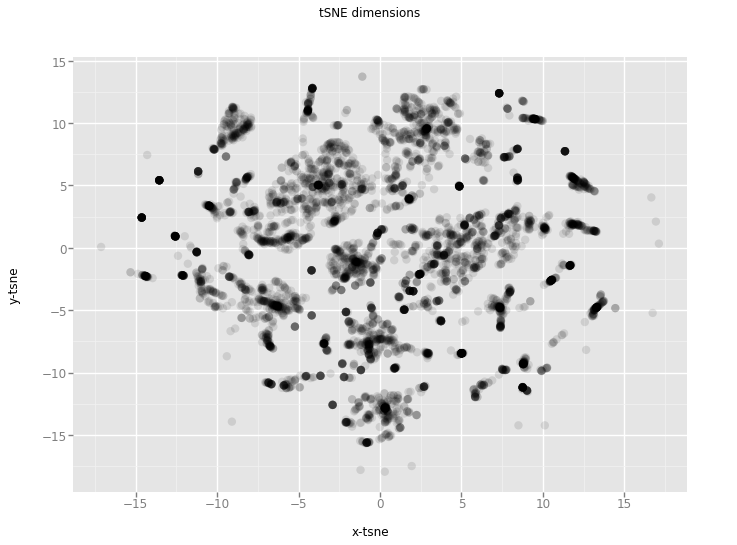

In [113]:
df_tsne = df_train_pca.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions")
chart.show()

We observe some clusters formed which do probably reflect the geographical clusters observed on the map.

A Truncated SVD technique inspired by Latent Semantic Analysis in NLP has also been tried by was not convincing.